In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
import os
import sys
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt

import pppc
from pppc.configs import InferenceConfigDict
from pppc.ptychonn.model import PtychoNNModel, PtychoNNTransposedConvModel
from pppc.reconstructor import DatasetInferencer, TileStitcher
from pppc.position_list import ProbePositionList
from pppc.io import NPZFileHandle

os.chdir('/data/programs/probe_position_correction_w_ptychonn/workspace/large')

In [39]:
matplotlib.rc('font',family='Times New Roman')
matplotlib.rcParams['font.size'] = 14
plt.viridis()

<Figure size 640x480 with 0 Axes>

In [40]:
def clean_data(arr):
    mask = arr < 0
    vals = arr[mask]
    vals = 32768 + (vals - -32768)
    arr[mask] = vals
    return arr

def plot_distribution(x):
    x = x.reshape(-1)
    #x = x[x > 0]
    plt.hist(x, bins=32)
    plt.semilogy()
    plt.show()

In [46]:
scan_idx = 235
save_figs = True

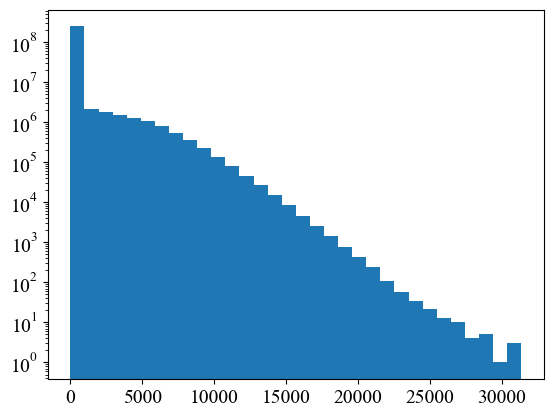

(961, 512, 512) int32


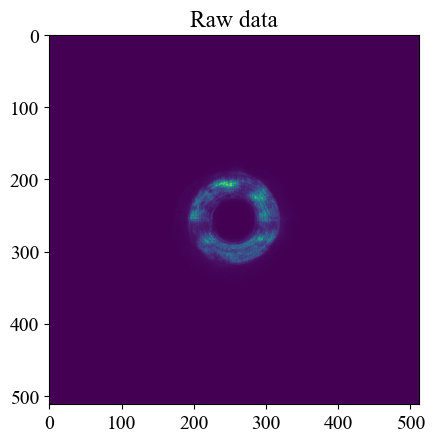

In [47]:
psize_nm = np.load('data/scan221_raw.npz')['pixelsize'] * 1e9
config_dict = InferenceConfigDict()
#config_dict['model_path'] = '../../trained_models/model_36SpiralDatasets_model_PtychoNNModel_nLevels_4_batchSizePerProcess_32_learningRatePerProcess_0.0001/best_model.pth'
config_dict['model_path'] = '../../trained_models/model_36SpiralDatasets_TransConv/best_model.pth'
config_dict['model'] = (PtychoNNTransposedConvModel, {'n_levels': 5})
config_dict['batch_size'] = 32
try:
    config_dict['dp_data_file_handle'] = NPZFileHandle('data/test{}.npz'.format(scan_idx))
except:
    config_dict['dp_data_file_handle'] = NPZFileHandle('data/scan{}.npz'.format(scan_idx))
# Correct int16 overflow values
config_dict['dp_data_file_handle'].array = clean_data(config_dict['dp_data_file_handle'].array)
plot_distribution(config_dict['dp_data_file_handle'].array)
print(config_dict['dp_data_file_handle'].array.shape, config_dict['dp_data_file_handle'].array.dtype)
plt.figure()
plt.imshow(config_dict['dp_data_file_handle'].array[0, :, :])
plt.title('Raw data')
plt.show()
# if 244 <= scan_idx <= 246: 
#     config_dict['dp_data_file_handle'].array = config_dict['dp_data_file_handle'].array.astype(float)
#     config_dict['dp_data_file_handle'].transform_data((128, 128), discard_len=(-64, -64))
# else:
config_dict['dp_data_file_handle'].transform_data((128, 128), discard_len=(64, 64))
config_dict['cpu_only'] = True
config_dict['prediction_output_path'] = 'outputs/pred_{}_{}'.format(
    os.path.splitext(os.path.basename(config_dict['dp_data_file_handle'].f.fid.name))[0],
    os.path.basename(os.path.dirname(config_dict['model_path'])))

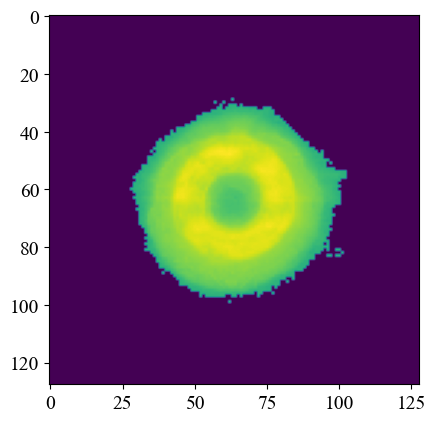

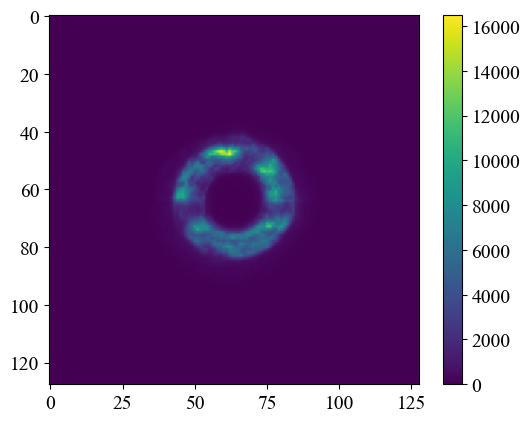

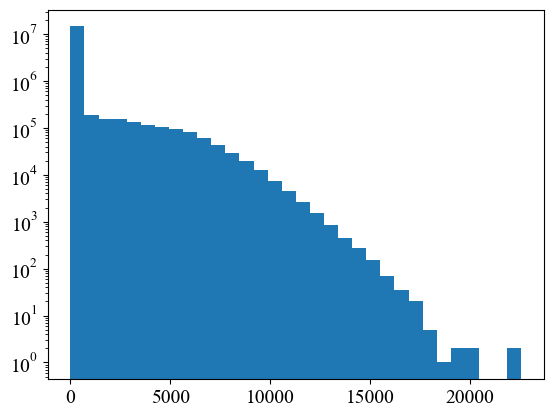

In [48]:
plt.figure()
plt.imshow(np.log10(config_dict['dp_data_file_handle'].array[0, :, :] + 1e-6))
plt.figure()
plt.imshow(config_dict['dp_data_file_handle'].array[0, :, :])
plt.colorbar()
plt.show()
plot_distribution(config_dict['dp_data_file_handle'].array[:, :, :])

In [49]:
inferencer = DatasetInferencer(config_dict)
inferencer.build()
inferencer.run()
inferencer.convert_output_files_into_single_tiff('pred_phase')
inferencer.convert_output_files_into_single_tiff('pred_amp')

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 929/961 [00:30<00:01, 30.07it/s]


## Stitching

In [31]:
#config_dict['probe_position_list'] = ProbePositionList(file_path='data/pos235.csv', unit='m', psize_nm=8, convert_to_pixel=False, first_is_x=False)
config_dict['probe_position_list'] = ProbePositionList(file_path='outputs/test{}/calc_pos_{}_collective_niters_2_beta_0p5_nn_12_sw_1e-2_1e-3.csv'.format(scan_idx, scan_idx), unit='m', psize_nm=8, convert_to_pixel=False, first_is_x=False)
#config_dict['probe_position_list'].array += 50 * 8e-9
config_dict['central_crop'] = (108, 108)

In [32]:
stitcher = TileStitcher(config_dict)
stitcher.build()
stitcher.run()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 961/961 [00:21<00:00, 43.78it/s]


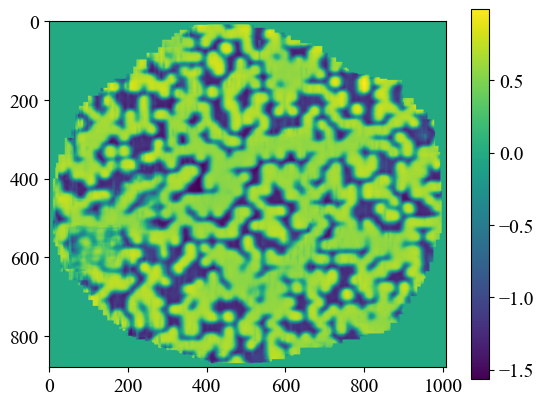

In [33]:
image_stitched_ptychonn = stitcher.image_stitched
fig, ax = plt.subplots(1, 1)
im = ax.imshow(image_stitched_ptychonn)
plt.colorbar(im)
if save_figs:
    plt.savefig('outputs/test{}/stitched_niters_2_nn_12_sw_1e-2_1e-3.pdf'.format(scan_idx))
else:
    plt.show()